In [13]:
import tensorflow as tf
import numpy as np
import pickle
import random
import re

from tensorflow.python.client import device_lib
from datetime import date

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import sys
#sys.path.append('/export/sabrina/RNA_struc_pred/2020-09-16_discriminator')
import rna_enc_pdb
import discr_funcs as funcs
import resnet_emb_funcs_elu_HPC_v2 as res_funcs

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = '0'#'0,1'
import pandas as pd
column_seq   = 0
column_z     = 1
column_drift = 2


def np_pad(matrix, pad_max, pad_val, n_classes, shift=0):
    M_pad = np.full([pad_max, pad_max, n_classes], pad_val)
    M_pad[shift:matrix.shape[0]+shift, shift:matrix.shape[1]+shift, :] = matrix
    return M_pad


params = {'seq_vocabsize': 4, 'N_value': 4, 'prob_N': 0.25, 'resnet_k': 3, 'data_format': 'channels_last', 'RNA_len':100,
          'pre_activation': True, 'loss_filter_fn': False, 'weight_decay': 0.0001, 'optimizer_adam_beta1': 0.9, 
          'optimizer_adam_beta2': 0.997, 'optimizer_adam_epsilon': 1e-09, 'N_GPUS': 4, 'n_iters': 100000, 
          'use_outline_padding': True,
          'default_batch_size': 100, 
          
          'n_classes': 3, 'learning_rate': 0.0001, 'warmup_steps': 0, 'alpha': 0.01, 
          'lr_decay': 0.9988, 'use_regularization': True, 'RNA_length': 100, 'padding': 0, 'n_dense_filter': 100, 
          'data_augmentation_shift': False, 'atrous_rate': 4, 'use_dilation': True, 'dilation_stdev': 0.01, 'resnet_filter': 5, 
          'block_sizes': 8, 
          'drift_train_file': '/export/sabrina/RNA_struc_pred/2020-09-16_discriminator/data/drift_train_shape_100_07072020_hierclust293clust.pkl', 'drift_valid_file': '/export/sabrina/RNA_struc_pred/2020-09-16_discriminator/data/drift_valid_shape_100_07072020_hierclust293clust.pkl', 'mean_field_train_file': '/export/sabrina/RNA_struc_pred/2020-09-16_discriminator/data/mean_field_ckpt_07072020_complete_loss_big_lr1e6_no_shape/mean_field_train_L100_07072020_big_no_shape_492000iter.pkl', 'mean_field_valid_file': '/export/sabrina/RNA_struc_pred/2020-09-16_discriminator/data/mean_field_ckpt_07072020_complete_loss_big_lr1e6_no_shape/mean_field_valid_L100_07072020_big_no_shape_492000iter.pkl', 'struc_vocab': 700, 'ckpt_dir': '/export/sabrina/RNA_struc_pred/2020-09-16_discriminator/ckpt/discr_big_no_shape_07072020_trained20200916/', 'figs_dir': '/export/sabrina/RNA_struc_pred/2020-09-16_discriminator/ckpt/discr_big_no_shape_07072020_trained20200916//plots/'}
params["N_GPUS"] = 1
params["default_batch_size"] = 80
params["batch_size"] = params["default_batch_size"] // params["N_GPUS"]
params.update({'dilation_stdev': 0.01, 'dilation_rate': 4} )
batch_size = params['default_batch_size']


enc_sq_pdb = rna_enc_pdb.RNAEncoder(L=params["RNA_length"], args="seq")
enc_db_pdb = rna_enc_pdb.RNAEncoder(L=params["RNA_length"], args="struc")

In [14]:
with open('/gpfs/scratch/ramakers/rnafold/data/drifts_vqvae100_3d_8_160k_23022022.pkl', 'rb') as f:
    traindata_df, valdata_df, testdata_df = pickle.load(f)   

In [15]:
with open('/gpfs/scratch/ramakers/rnafold/data/meanfields_23022022.pkl', 'rb') as f:
    tmp_idx_dict, val_idx_dict, test_idx_dict = pickle.load(f)
print('Done.')

Done.


In [16]:
traindata_df = traindata_df[['subseq', 'z']]
valdata_df   = valdata_df[['subseq', 'z']]
testdata_df  = testdata_df[['subseq', 'z']]

In [17]:
rnd_truth = []
for s in traindata_df.index:
    if 'seed' in s:rnd_truth.append(s)

mf_keys = list(tmp_idx_dict.keys())
trainvals = {}
cnt = 0
for s in rnd_truth:
    pdb_key = s.split('.')[0][:6]
    if pdb_key not in traindata_df.index:
        cnt+=1
    else:
        pdb_key = s.split('.')[0][:6]
        subseq = traindata_df.loc[pdb_key, 'subseq']
        subseq = np.array(enc_sq_pdb.encode(subseq)).reshape(1,100)
        z      = traindata_df.loc[pdb_key, 'z']
        driftz = traindata_df.loc[s,'z']
        trainvals.update({s : [subseq, z, driftz]})     

for s in mf_keys:
    pdb_key = s.split('.')[0][:6]
    if pdb_key in traindata_df.index:
        subseq = traindata_df.loc[pdb_key, 'subseq']
        subseq = np.array(enc_sq_pdb.encode(subseq)).reshape(1,100)
        z      = traindata_df.loc[pdb_key, 'z']
        trainvals.update({s+'_mf' : [subseq, z, tmp_idx_dict[s][0]]}) 
        

        
rnd_truth = []
for s in valdata_df.index:
    if 'seed' in s:rnd_truth.append(s)
        
mf_keys = list(val_idx_dict.keys())
validvals = {}
cnt = 0
for s in rnd_truth:
    pdb_key = s.split('.')[0][:6]
    if pdb_key not in valdata_df.index:
        cnt+=1
    else:
        pdb_key = s.split('.')[0][:6]
        subseq = valdata_df.loc[pdb_key, 'subseq']
        subseq = np.array(enc_sq_pdb.encode(subseq)).reshape(1,100)
        z      = valdata_df.loc[pdb_key, 'z']
        
        driftz = valdata_df.loc[s,'z']
        validvals.update({s : [subseq, z, driftz]})     

for s in mf_keys:
    pdb_key = s.split('.')[0][:6]
    if pdb_key in valdata_df.index:
        subseq = valdata_df.loc[pdb_key, 'subseq']
        subseq = np.array(enc_sq_pdb.encode(subseq)).reshape(1,100)
        z      = valdata_df.loc[pdb_key, 'z']
        validvals.update({s+'_mf' : [subseq, z, val_idx_dict[s][0]]}) 
        
        
        
rnd_truth = []
for s in testdata_df.index:
    if 'seed' in s:rnd_truth.append(s)
        
mf_keys = list(test_idx_dict.keys())
testvals = {}
cnt = 0
for s in rnd_truth:
    pdb_key = s.split('.')[0][:6]
    if pdb_key not in testdata_df.index:
        cnt+=1
    else:
        pdb_key = s.split('.')[0][:6]
        subseq = testdata_df.loc[pdb_key, 'subseq']
        subseq = np.array(enc_sq_pdb.encode(subseq)).reshape(1,100)
        z      = testdata_df.loc[pdb_key, 'z']
        driftz = testdata_df.loc[s,'z']
        testvals.update({s : [subseq, z, driftz]})     

for s in mf_keys:
    pdb_key = s.split('.')[0][:6]
    if pdb_key in testdata_df.index:
        subseq = testdata_df.loc[pdb_key, 'subseq']
        subseq = np.array(enc_sq_pdb.encode(subseq)).reshape(1,100)
        z      = testdata_df.loc[pdb_key, 'z']
        testvals.update({s+'_mf' : [subseq, z, test_idx_dict[s][0]]}) 

In [18]:
#### sanity check for: shapes match
for k in trainvals.keys():
    k1 = trainvals[k][1]
    k2 = trainvals[k][2]
    
    if k1.shape != k2.shape:
        print(k)

In [19]:
trainvals = pd.DataFrame.from_dict(trainvals, orient='index')
trainvals['pdbid'] = trainvals.index

validvals = pd.DataFrame.from_dict(validvals, orient='index')
validvals['pdbid'] = validvals.index

testvals = pd.DataFrame.from_dict(testvals, orient='index')
testvals['pdbid'] = testvals.index

traindata = trainvals.values
valdata = validvals.values
testdata = testvals.values

# define model

In [20]:
def model_fn(inputs_raw, emb_raw, shift_vals, params, training):
    
    # onehot.shape == [b,L,4]
    onehot = tf.one_hot(indices=inputs_raw, depth=params["seq_vocabsize"])        
    # check if "N" (== value of 4) is in inputs and mask every nucleotide in onehot with 0.25
    equal_N = tf.to_float(tf.equal(inputs_raw, params["N_value"])) * params["prob_N"]
    tile_eq_N = tf.tile(tf.expand_dims(equal_N, axis=-1), [1,1,params["seq_vocabsize"]])
    onehot = onehot + tile_eq_N
    
    # reshape_onehot.shape == [b,4,L,1], reshape_onehot_T.shaoe == [b,4,1,L]
    reshape_onehot = tf.expand_dims(tf.transpose(onehot, perm=[0,2,1]), axis=3)
    reshape_onehot_T = tf.transpose(reshape_onehot, perm=[0,1,3,2])
    # s.shape == [b,4,L,L], sT.shape == [b,4,L,L]
    s = reshape_onehot * tf.ones_like(reshape_onehot_T)
    sT = reshape_onehot_T * tf.ones_like(reshape_onehot)
    # M.shape == [b,8,L,L]
    M = tf.concat([s,sT], axis=1)
    
    # pad original seq_len to max_len with pad_val == -1
    equal = tf.to_float(tf.not_equal(inputs_raw, -1))
    tile = tf.tile(tf.reshape(equal, [-1, 1, params["RNA_length"], 1]), [1, 1, 1, params["RNA_length"]])
    pad_mask = tile * tf.transpose(tile, perm=[0,1,3,2]) 
    M_pad = M * pad_mask
    
    # onehot_tar.shape == [b,n_classes,L,L]
    onehot_emb = tf.to_float(tf.transpose(emb_raw, perm=[0,3,1,2]))
    
    # diag frame.shape == [b,1,L,L]
    diag_frame = tf.matrix_band_part(tf.ones([tf.shape(M_pad)[0], 1, params["RNA_length"], params["RNA_length"]]), 0, 0)
    diag_frame = diag_frame * pad_mask
    
    # t_STACK.shape == [b,L,L,8+1+n_classes]
    STACK = tf.concat([M_pad, onehot_emb, diag_frame], axis=1)
    t_STACK = tf.transpose(STACK, perm=[0,2,3,1])
    print("t_STACK.shape ==", t_STACK.shape)
    
    
    inputs = res_funcs.conv2d_layer(t_STACK, params, 'conv_prev', args='first_conv', raw_sq_input=inputs_raw, pad_mask=pad_mask, shift_vals=shift_vals)
    #return inputs
    
    for i, num_blocks in enumerate(range(params["block_sizes"])):
        inputs = res_funcs.block_layer(i, inputs, training, params)
    
    if params["pre_activation"]:
        inputs_bn   = res_funcs.batch_norm(inputs, training, params["data_format"], 'batch_norm_pre_activation')
        inputs_relu = tf.nn.relu(inputs_bn)
        dense1 = tf.layers.conv2d(inputs=inputs_relu, filters=params["n_dense_filter"], kernel_size=[1,1], strides=[1,1], padding='VALID', name='dense1')
    else:
        inputs_relu = tf.nn.relu(inputs)
        dense1 = tf.layers.conv2d(inputs=inputs_relu, filters=params["n_dense_filter"], kernel_size=[1,1], strides=[1,1], padding='VALID', name='dense1')
    
    dense2 = tf.nn.relu(dense1)
    dense2 = tf.layers.conv2d(inputs=dense2, filters=1, kernel_size=[1,1], strides=[1,1], padding='VALID', name='dense2')
    
    # logits.shape == [b,1]
    logits = tf.reduce_sum(dense2, axis=[1,2])
    
    return logits

In [21]:
params["batch_size"]

80

In [22]:
tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    
    with tf.variable_scope('resnet', reuse=tf.AUTO_REUSE):
        
        tconfig=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
        c1 = []
        c2 = []
        device_list = [x.name for x in device_lib.list_local_devices() if x.device_type == 'GPU']
        print("device_list: %s \n" % device_list)
        
        sq_ph        = tf.placeholder(tf.int32, [None, params["RNA_len"]])
        emb_pdb_ph   = tf.placeholder(tf.int32, [None, params["RNA_len"], params["RNA_len"]])
        emb_drift_ph = tf.placeholder(tf.int32, [None, params["RNA_len"], params["RNA_len"]])
        train_ph     = tf.placeholder(tf.bool, ())
        cl_ph        = tf.placeholder(tf.float32, [None, 1])
        shift_ph     = tf.placeholder(tf.int32, [None,1])
        step_ph      = tf.placeholder(tf.float32, ())
        

        
        start_idx = 0
        #if True:
        for d in device_list:
            #if True:
            with tf.device(d):
                #print("\nwith device %s \n" % d)
                sq_gpu        = sq_ph[start_idx:start_idx + params["batch_size"]]
                emb_pdb_gpu   = tf.one_hot(emb_pdb_ph[start_idx:start_idx + params["batch_size"]], params["n_classes"] )
                emb_drift_gpu = tf.one_hot(emb_drift_ph[start_idx:start_idx + params["batch_size"]], params["n_classes"] )
                cl_gpu        = cl_ph[start_idx:start_idx + params["batch_size"]]
                shift_gpu     = shift_ph[start_idx:start_idx + params["batch_size"]]
                
                
                #ym_mask = res_funcs.get_target_mask_distributed_v2(sq_gpu, shift_gpu, discr_params)
                #nd_mask = sym_mask #* tf.random.uniform((discr_params['batch_size'], params["n_classes"], params["RNA_length"], params["RNA_length"]))
                
                logits_1 = model_fn(sq_gpu, emb_pdb_gpu, shift_gpu, params,train_ph)
                logits_2 = model_fn(sq_gpu, emb_drift_gpu, shift_gpu, params, train_ph)
                logits = logits_1 - logits_2
                print('logits_1.shape == %s' % logits_1.shape)
                print('logits_2.shape == %s' % logits_2.shape)
                print("\nNumber of discr_params (energy network): %s \n" % funcs.get_num_of_params())
                
                loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=cl_gpu, logits=logits))
                c1.append(loss)
                
                preds = tf.round(tf.nn.sigmoid(logits))
                acc = tf.reduce_mean(tf.cast(tf.equal(preds, cl_gpu), tf.float32))
                c2.append(acc)
                
            start_idx = start_idx + params["batch_size"]
                
        with tf.device('/cpu:' + str([x.name for x in device_lib.list_local_devices() if x.device_type == 'CPU'][0][-1])):
            loss = tf.add_n(c1) / params['N_GPUS']
            acc  = tf.add_n(c2) / params['N_GPUS']
            
            
            def exclude_batch_norm(name):
                return 'batch_normalization' not in name

            if params["use_regularization"]:
                loss_filter_fn = params["loss_filter_fn"] or exclude_batch_norm
                l2_loss = params["weight_decay"] * tf.add_n([tf.nn.l2_loss(tf.cast(v, tf.float32)) for v in tf.trainable_variables() if loss_filter_fn(v.name)])
                loss = loss + l2_loss
            
            
            lr = funcs.get_lr(params["learning_rate"], step_ph, params["lr_decay"])
            #lr = tf.constant(discr_params["learning_rate"], dtype=tf.float32)
            #lr = funcs.lr_decay(discr_params["learning_rate"], params["lr_decay"], step_ph)
            optimizer = tf.contrib.opt.LazyAdamOptimizer(lr, beta1=params["optimizer_adam_beta1"],
                                                         beta2=params["optimizer_adam_beta2"], 
                                                         epsilon=params["optimizer_adam_epsilon"])
            global_step = tf.train.get_global_step()
            tvars = tf.trainable_variables()

            gradients = optimizer.compute_gradients(loss, tvars, colocate_gradients_with_ops=True)
            minimize_op = optimizer.apply_gradients(gradients, global_step=global_step, name="train")
            update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
            train_op = tf.group(minimize_op, update_ops)

            init_op = tf.global_variables_initializer()
            
            
        saver = tf.train.Saver()
        
        #print("\nTRAINABLE VARIABLES:")
        #for i in tf.trainable_variables():
        #    print(i)
            
    print("\nDone graph init...")

device_list: ['/device:GPU:0'] 

t_STACK.shape == (?, 100, 100, 12)


t_STACK.shape == (?, 100, 100, 12)


logits_1.shape == (80, 1)
logits_2.shape == (80, 1)

Number of discr_params (energy network): 5056 


Done graph init...


In [34]:
zero_shift    = np.array([[0] for _ in range(batch_size)])
perfect_class = np.array([[1] for _ in range(batch_size)])

def batch():
    batch_rnd = traindata[np.random.choice(traindata.shape[0], batch_size, replace=False)]
    pdb_ids = batch_rnd[:, -1]
    return np.concatenate(batch_rnd[:,column_seq]), np.stack(batch_rnd[:,column_z]),\
            np.stack(batch_rnd[:,column_drift]),  pdb_ids 


def valbatch():
    batch_rnd = valdata[np.random.choice(valdata.shape[0], batch_size, replace=True)]
    pdb_ids = batch_rnd[:, -1]
    return np.concatenate(batch_rnd[:,column_seq]), np.stack(batch_rnd[:,column_z]),\
            np.stack(batch_rnd[:,column_drift]),  pdb_ids 

In [35]:
print('Done preprocessing.')

Done preprocessing.


In [ ]:
params["n_iters"] = 1000000
tlr_list = []
tloss_list = []
tacc_list = []
vloss_list = []
vacc_list = []
with tf.Session(graph=g, config=tconfig) as sess:
    sess.run(init_op)
    
    loss_lst, acc_lst, lr_lst = [], [], []
    val_loss_lst, val_acc_lst, val_lr_lst, val_iter = [], [], [], []


    for i in range(params["n_iters"]):
        
        sq_batch, emb_pdb_batch, emb_drift_batch, pdbs = batch()
        
        
        ###### random flipping of embedding vs drift ########
        cls_labels = []
        cnt = 0
        for i1, i2 in zip( emb_pdb_batch, emb_drift_batch):
            if np.random.rand() < 0.5:
                cls_labels.append([0])
                tmp = emb_pdb_batch[cnt].copy()
                emb_pdb_batch[cnt]   = emb_drift_batch[cnt]
                emb_drift_batch[cnt] = tmp
            else:
                cls_labels.append([1])
            cnt += 1

        cls_labels = np.array(cls_labels)


        _, loss_np, acc_np, lr_np = sess.run([train_op, loss, acc, lr], feed_dict={sq_ph: sq_batch, 
                                                                                   emb_pdb_ph: emb_pdb_batch, 
                                                                                   emb_drift_ph: emb_drift_batch,
                                                                                   cl_ph:     cls_labels  ,
                                                                                   shift_ph: zero_shift,
                                                                                   train_ph: True, step_ph: i})
        tloss_list.append(loss_np)
        tacc_list.append(acc_np)
        tlr_list.append(lr_np)
        
        if (i % 1000) == 0:
            
            sq_batch, emb_pdb_batch, emb_drift_batch, pdbs = valbatch()
        
        
            ###### random flipping of embedding vs drift ########
            cls_labels = []
            cnt = 0
            for i1, i2 in zip( emb_pdb_batch, emb_drift_batch):
                if np.random.rand() < 0.5:
                    cls_labels.append([0])
                    tmp = emb_pdb_batch[cnt].copy()
                    emb_pdb_batch[cnt]   = emb_drift_batch[cnt]
                    emb_drift_batch[cnt] = tmp
                else:
                    cls_labels.append([1])
                cnt += 1

            cls_labels = np.array(cls_labels)


            vloss_np, vacc_np = sess.run([ loss, acc], feed_dict={sq_ph: sq_batch, 
                                                                                       emb_pdb_ph: emb_pdb_batch, 
                                                                                       emb_drift_ph: emb_drift_batch,
                                                                                       cl_ph:     cls_labels  ,
                                                                                       shift_ph: zero_shift,
                                                                                       train_ph: True, step_ph: i})

            vloss_list.append(vloss_np)
            vacc_list.append(vacc_np)    
            print(i, loss_np, end=' - ')
            
        if (i % 10000) == 0:
            save_file =  '/gpfs/scratch/ramakers/discr/ckpt/discr_{0}.ckpt'.format(i)
            save_path = saver.save(sess, save_file)
            #print('##### saved ckpt:', i)
            #plt.plot(range(len(loss_lst)), loss_lst),plt.show()
            #print('~~~~~~~~~~~')

0 10.064486 - 

In [45]:
#with open('/gpfs/scratch/ramakers/discr/ckpt/losses.pkl', 'wb') as f:
#    pickle.dump([tloss_list, tacc_list, tlr_list, vloss_list, vacc_list], f)

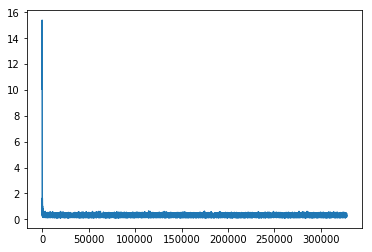

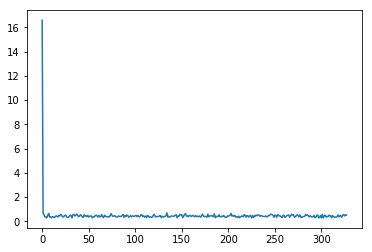

In [44]:
plt.plot(range(len(tloss_list)),tloss_list)
plt.show()
plt.plot(range(len(vloss_list)),vloss_list)
plt.show()